In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import requests 
from collections import Counter

In [19]:
##------------------------------Pegando os Dados-----------------------------------

url = "https://apitempo.inmet.gov.br/estacao/diaria/2018-01-01/2020-12-31/A307"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
resp = requests.get(url, headers=headers)
df = None
if resp.status_code != 200:
    print (resp.raise_for_status())
else:
    df = pd.DataFrame(resp.json())
    #df = df[df["TEM_MAX"].astype('float') ]
    df_temp = df[df['TEMP_MAX'].notnull()]
    df_temp = df[df['UMID_MED'].notnull()]
    
    df_temp = df[['TEMP_MAX', 'UMID_MED']]
    df_temp["id"] = df.index + 1 

    df_umid = df[df['UMID_MED'].notnull()]
    df_umid = df[['UMID_MED']]
    #df_umid["id"] = df.index + 1

<ipython-input-19-fb496ac972b8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["id"] = df.index + 1


In [137]:
#------------------------------Tratando os Dados-----------------------------------

count_row_temp = df_temp.shape[0]

qtd_training_temp = int(count_row_temp/3) * 2

df_training_temp = df_temp.sample(qtd_training_temp) # 2/3 de dados de treino

count_training_temp = int((df_training_temp.shape[0] * 5) / 100)
df_training_temp_anomalie_edit = df_training_temp.sample(count_training_temp) #1% de dos dados de treino editados
df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit]).drop_duplicates(keep=False)
df_training_temp_anomalie_edit.dropna(inplace=True)
#df_training_temp_anomalie_edit.loc[df_training_temp_anomalie_edit['TEMP_MAX'] == None,'TEMP_MAX'] = 0
#df_training_temp_anomalie_edit.loc[df_training_temp_anomalie_edit['UMID_MED'] == None,'TEMP_MAX'] = 0

df_training_temp_anomalie_edit["TEMP_MAX"] = df_training_temp_anomalie_edit["TEMP_MAX"].astype(float)
df_training_temp_anomalie_edit["UMID_MED"] = df_training_temp_anomalie_edit["UMID_MED"].astype(float)

valorMediaTemp = df_training_temp_anomalie_edit['TEMP_MAX'].sum()/df_training_temp_anomalie_edit.shape[0]
valorMediaUmid = df_training_temp_anomalie_edit['UMID_MED'].sum()/df_training_temp_anomalie_edit.shape[0]

desvioPadraoTemp = df_training_temp_anomalie_edit["TEMP_MAX"].std()
desvioPadraoUmid = df_training_temp_anomalie_edit["UMID_MED"].std()

desvioPadraoEditadoTemp = 3 * desvioPadraoTemp
desvioPadraoEditadoUmid = 3 * desvioPadraoUmid

#df_training_temp_anomalie_edit.loc[df_training_temp_anomalie_edit['TEMP_MAX']>0,'TEMP_MAX'] = desvioPadraoEditado + valorMediaTemp

valorFinalTemp = desvioPadraoEditadoTemp + valorMediaTemp
valorFinalUmid = desvioPadraoEditadoUmid + valorMediaUmid

df_training_temp_anomalie_edit["TEMP_MAX"] = df_training_temp_anomalie_edit["TEMP_MAX"].add(valorFinalTemp)
df_training_temp_anomalie_edit["UMID_MED"] = df_training_temp_anomalie_edit["UMID_MED"].add(valorFinalUmid)

df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit])
df_training_temp.sort_values(by=['id'])

df_test_temp = pd.concat([df_temp, df_training_temp]).drop_duplicates(keep=False)

#Treino
df_training_temp["TEMP_MAX"] = df_training_temp["TEMP_MAX"].astype(float)
df_training_temp["UMID_MED"] = df_training_temp["UMID_MED"].astype(float)
df_training_temp.dropna(inplace=True)
df_training_temp = df_training_temp.drop(columns='id')

print ("Valor adicionado Temperatura: ")
print (valorFinalTemp)
print ()
print ("Valor adicionado Umidade: ")
print (valorFinalUmid)
print ()
print (df_training_temp.sort_values(by=['TEMP_MAX']))

#Teste


Valor adicionado Temperatura: 
40.55265788071856

Valor adicionado Umidade: 
78.16220164741307

       TEMP_MAX    UMID_MED
752   25.100000   81.200000
554   25.700000   69.800000
555   25.900000   64.400000
564   26.300000   59.900000
337   26.400000   80.100000
...         ...         ...
1018  76.652658  119.262202
317   76.752658  115.962202
314   77.052658  119.962202
721   77.852658  116.462202
692   80.652658  111.162202

[666 rows x 2 columns]


Número estimado de clusters: 2
Número estimado de pontos de ruído: 0


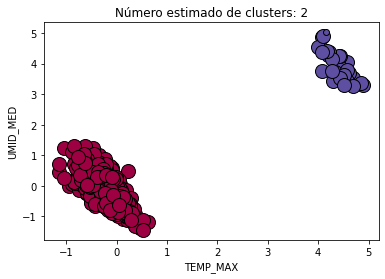

In [128]:
#------------------------------Implementando o DBSCAN-----------------------------------

X = np.array(df_training_temp)
X, labels_true = make_blobs(n_samples=df_training_temp.shape[0], centers=X, cluster_std=0.4,random_state=None)
X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.5, min_samples=5,
                    metric='euclidean', algorithm='auto', leaf_size=30).fit(X)

#print (df_training_temp.sort_values(by=['TEMP_MAX']))

#from sklearn.model_selection import train_test_split
#X_train, X_teste, y_train, y_test = train_test_split(X, y)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

labels = db.labels_
#print (labels)

outliers = df_training_temp[db.labels_ == -1]

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

#print ("Outliers:")
#print (outliers.sort_values(by=['TEMP_MAX']))

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Preto usado para ruído
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

print('Número estimado de clusters: %d' % n_clusters_)
print('Número estimado de pontos de ruído: %d' % n_noise_)

'''
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))
'''

plt.title('Número estimado de clusters: %d' % n_clusters_)
plt.xlabel("TEMP_MAX")
plt.ylabel("UMID_MED")
plt.show()

#sns.scatterplot(x=X[:,0], y=X[:,1])
#sns.scatterplot(x=outliers[:,0], 
#                y=outliers[:,1], color='black')
#plt.title("DBSCAN", fontsize=15, pad=15)
#plt.savefig("DBSCAN.png", dpi=80)

In [111]:
#------------------------------Outra Tentativa o DBSCAN-----------------------------------
import seaborn as sns

X = np.array(df_training_temp)
X, labels_true = make_blobs(n_samples=df_training_temp.shape[0], centers=X, cluster_std=0.4,random_state=None)
X = StandardScaler().fit_transform(X)

db = DBSCAN(eps=0.5, min_samples=5, 
                    metric='euclidean', algorithm='auto').fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

outliers = df_training_temp[db.labels_ == -1]


n_noise_ = list(labels).count(-1)
print ("Outliers:")
print (outliers)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

outl_df = df_training_temp[db.labels_ == -1]
clust_df = df_training_temp[db.labels_ != -1]

colors = db.labels_
colors_clusters = colors[colors != -1]
colors_out = 'yellow'
    
clusters = Counter(db.labels_)
#print (df_dados_plt[model_test.labels_ == -1].head())
#print ('Número de Clusters: {}'.format(len(clusters) -1 ))
#print ()    
#fig = plt.figure()
ax = fig.add_axes([.1, .1, 1, 1])
ax.scatter(clust_df['TEMP_MAX'], clust_df['UMID_MED'], c = colors_clusters, edgecolors = 'black', s=50)
ax.scatter(outl_df['TEMP_MAX'], outl_df['UMID_MED'], c = colors_out, edgecolors = 'black', s=50)


#ax.set_xlabel('TEMP_MAX', fontsize=9)
#ax.set_ylabel('UMID_MED', fontsize=9)
#plt.title('DBSCAN', fontsize=12)
#plt.grid(which='major', color='#cccccc', alpha=0.45)
#plt.show()


Outliers:
Empty DataFrame
Columns: [TEMP_MAX, UMID_MED]
Index: []


<ipython-input-111-c9e5b223fa32>:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_axes([.1, .1, 1, 1])


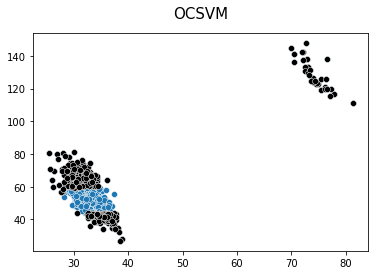

In [147]:
from sklearn.svm import OneClassSVM
import seaborn as sns

X = np.array(df_training_temp)
X, _ = make_blobs(n_samples=df_training_temp.shape[0], centers=X, cluster_std=0.4,random_state=None)

ocsvm = OneClassSVM(kernel='rbf', degree=3, gamma='scale', nu=0.5, coef0=0.0,tol=0.001,
                    shrinking=True,cache_size=200,
                    verbose=False,max_iter=-1).fit(X)
pred = ocsvm.predict(X)
outlier_index = np.where(pred==-1)
outlier_values = X[outlier_index]

sns.scatterplot(x=X[:,0], y=X[:,1])
sns.scatterplot(x=outlier_values[:,0], 
                y=outlier_values[:,1], color='black')
plt.title("OCSVM", fontsize=15, pad=15)
plt.savefig("One-Class SVM Detection.png", dpi=80)

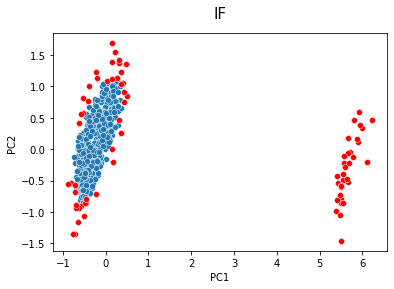

In [138]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

X = np.array(df_training_temp)
iforest = IsolationForest(n_estimators=100, max_samples=df_training_temp.shape[0], 
                          warm_start=False,
                          contamination='auto', max_features=1.0, 
                          bootstrap=False, n_jobs=None, random_state=None)

pred = iforest.fit_predict(X)
outlier_index = np.where(pred==-1)
outlier_values = X[outlier_index]


sc=StandardScaler()
X_scaled = sc.fit_transform(X)
outlier_values_scaled = sc.transform(outlier_values)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
outlier_values_pca = pca.transform(outlier_values_scaled)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
sns.scatterplot(x=outlier_values_pca[:,0], 
                y=outlier_values_pca[:,1], color='r')
plt.title("IF", fontsize=15, pad=15)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig("Isolation Forest Detection.png", dpi=80)